In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
# !apt-get install -y xvfb x11-utils
# !pip install pyvirtualdisplay==0.2.*

In [ ]:
# from pyvirtualdisplay import Display
# display = Display(visible=False, size=(1400, 900))
# _ = display.start()

In [ ]:
# from gym.wrappers.monitoring.video_recorder import VideoRecorder
# before_training = "before_training.mp4"

# video = VideoRecorder(env, before_training)
# # returns an initial observation
# env.reset()
# for i in range(200):
#   env.render()
#   video.capture_frame()
#   # env.action_space.sample() produces either 0 (left) or 1 (right).
#   observation, reward, done, info = env.step(env.action_space.sample())
#   # Not printing this time
#   #print("step", i, observation, reward, done, info)

# video.close()
# env.close()

In [ ]:
# from base64 import b64encode
# def render_mp4(videopath: str) -> str:
#   """
#   Gets a string containing a b4-encoded version of the MP4 video
#   at the specified path.
#   """
#   mp4 = open(videopath, 'rb').read()
#   base64_encoded_mp4 = b64encode(mp4).decode()
#   return f'<video width=400 controls><source src="data:video/mp4;' \
#          f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
# from IPython.display import HTML
# html = render_mp4(before_training)
# HTML(html)

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('Acrobot-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print('state_shape ',state_shape)
print('no_of_actions ',no_of_actions)
print('env.action_space.sample() ',env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print('state ', state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print('action ',action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print('next_state ', next_state)
print('reward ',reward)
print('done ',done)
print('info ',info)
print("----")


state_shape  6
no_of_actions  3
env.action_space.sample()  2
----
state  [ 0.99962485  0.02738891  0.9989402  -0.04602639 -0.09180529 -0.09669447]
----
action  2
----
next_state  [ 0.99996984 -0.0077642   0.9997182  -0.02373883 -0.25169677  0.31000718]
reward  -1.0
done  False
info  {}
----


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)



class QNetworkDueling(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model."""
        super(QNetworkDueling, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Common feature extraction layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # State value function
        self.fc3_val = nn.Linear(fc2_units, 1)

        # Advantage function
        self.fc3_adv = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # State value calculation
        val = self.fc3_val(x)

        # Advantage value calculation
        adv = self.fc3_adv(x)

        # Combine state value and advantage to get Q-value
        return val + adv - adv.mean()


In [5]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [6]:
class TutorialAgentDueling():

    def __init__(self, state_size, action_size, seed):
        # Agent Environment Interaction
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetworkDueling(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetworkDueling(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get mean predicted Q values (for next states) from target model
        # Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().mean(dim=1).unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient Clipping
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()


In [7]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

In [8]:
def dueling_dqn(n_episodes=600, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores_window = deque(maxlen=100)
    eps = eps_start
    episodes = []
    avg_rewards = []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        eps = max(eps_end, eps_decay*eps)

        episodes.append(i_episode)
        avg_rewards.append(np.mean(scores_window))

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= -100.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break

    return episodes, avg_rewards


In [9]:
begin_time = datetime.datetime.now()

agent = TutorialAgentDueling(state_size=state_shape, action_size=action_shape, seed=0)
episodes, avg_rewards = dueling_dqn()


time_taken = datetime.datetime.now() - begin_time

print(time_taken)


Episode 100	Average Score: -362.56
Episode 200	Average Score: -165.14
Episode 300	Average Score: -138.74
Episode 400	Average Score: -126.88
Episode 500	Average Score: -121.55
Episode 600	Average Score: -114.41
0:07:51.987567


Environment solved in 690 episodes!	Average Score: -99.96
0:12:00.832411

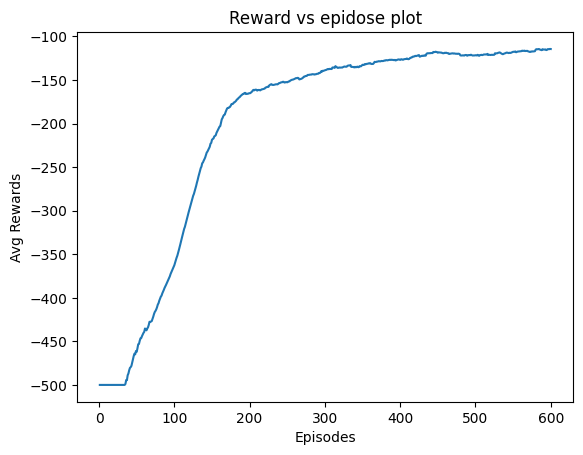

In [10]:
import matplotlib.pyplot as plt

plt.plot(episodes, avg_rewards)
plt.xlabel("Episodes")
plt.ylabel("Avg Rewards")
plt.title("Reward vs epidose plot")
plt.show()

In [ ]:
# after_training = "after_training.mp4"
# after_video = VideoRecorder(env, after_training)
# observation = env.reset()

# done = False
# display = Display(visible=False, size=(1400, 900))
# _ = display.start()
# while not done:
#   env.render()
#   after_video.capture_frame()
#   action = agent.act(observation)
#   observation, reward, done, info = env.step(action)
# after_video.close()
# env.close()
# # You should get a video similar to the one below.
# html = render_mp4(after_training)
# HTML(html)